Análise das relações

In [3]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", 

In [4]:
#!py -m spacy download en_core_web_sm


In [5]:
NER = spacy.load("en_core_web_sm")

In [6]:
import os

livros = [b for b in os.scandir('the-complete-works-of-agatha-christie') if '.txt' in b.name]

In [7]:
livro = livros[1]
with open(livro, "r", encoding="utf-8", errors="replace") as f:
    livro_texto = f.read()

livro_doc = NER(livro_texto)

In [8]:
displacy.render(livro_doc[0:2000],style="ent",jupyter=True)

Carregando os nomes dos personagens

In [18]:
personagens_df = pd.read_csv('personagens.csv', header=None)

In [19]:
personagens_df.head()

,0
0,Alexander Eastley
1,Alfred Crackenthorpe
2,Alice Crackenthorpe
3,Anna Stravinska
4,Archibald Spate


In [22]:
personagens_df.columns = ['nome_completo']

In [44]:
personagens_df['sobrenome'] = personagens_df['nome_completo'].apply(
    lambda x: x.split(' ', 1)[1] if ' ' in x else x
)


In [45]:
personagens_df.head()

,nome_completo,personagens_prenome,sobrenome
0,Alexander Eastley,Alexander,Eastley
1,Alfred Crackenthorpe,Alfred,Crackenthorpe
2,Alice Crackenthorpe,Alice,Crackenthorpe
3,Anna Stravinska,Anna,Stravinska
4,Archibald Spate,Archibald,Spate


Named entities

In [46]:
sent_entidades_df = []

for sent in livro_doc.sents:
    lista_entidades = [ent.text for ent in sent.ents]
    sent_entidades_df.append({'sentence':sent, 'entities': lista_entidades})

In [47]:
sent_entidades_df = pd.DataFrame(sent_entidades_df)
sent_entidades_df

,sentence,entities
0,"(\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n, Agatha,...","[Agatha Christie\n\n\nA Caribbean Mystery, Joh..."
1,"(A, Death, in, the, Hotel, \n\n\n\n\n, 4, ., \...","[Hotel, 4, Marple Seeks Medical Attention, 5]"
2,"(Miss, Marple, Makes, a, Decision, \n\n\n\n\n,...",[6]
3,"(In, the, Small, Hours, \n\n\n\n\n, 7, ., \n \...","[7, Beach, 8]"
4,"(A, Talk, with, Esther, Walters, \n\n\n\n\n, 9...","[Esther Walters, 9]"
...,...,...
4495,"(All, rights, reserved, , under, Internationa...","[International, Pan-American Copyright Convent..."
4496,"(By, payment, of, the, required, fees, ,, you,...",[]
4497,"(No, part, of, this, text, may, be, reproduced...",[]
4498,"(Library, of, Congress, Cataloging, -, in, -, ...",[]


In [51]:
def filter_entity(lista_entidades,personagens_df):
    return [ent for ent in lista_entidades if ent in list(personagens_df.nome_completo) or ent in list(personagens_df.sobrenome)]

In [53]:
sent_entidades_df['personagens'] = sent_entidades_df['entities'].apply(lambda x: filter_entity(x,personagens_df))

In [58]:
#Filtra as sentenças sem entidades do DataFrame
sent_entidades_df_filtrado = sent_entidades_df[sent_entidades_df['personagens'].map(len)>0]
sent_entidades_df_filtrado.head()

,sentence,entities,personagens
4,"(A, Talk, with, Esther, Walters, \n\n\n\n\n, 9...","[Esther Walters, 9]",[Esther Walters]
5,"(Miss, Prescott, and, Others, \n\n\n\n\n, 10, ...","[Prescott, 10]",[Prescott]
8,"(Exit, Victoria, Johnson, \n\n\n\n\n, 14, ., \...","[Victoria Johnson, 14]",[Victoria Johnson]
18,"(Miss, Marple, Uses, Her, Imagination, \n\n\n\...","[Agatha Christie, One, TORY, Kenya, Major Palg...",[Major Palgrave]
23,"(Whilst, Major, Palgrave, proceeded, with, the...",[Palgrave],[Palgrave]


In [59]:
#Aqui o código original filtra para só pegar o prenome dos personagens. Resolvi deixar comentado por enquanto
#sent_entidades_df_filtrado['personagens'] = sent_entidades_df_filtrado['personagens'].apply(lambda x: [item.split()[0] for item in x])

In [60]:
pd.reset_option('^display.',silent=True)
sent_entidades_df_filtrado

,sentence,entities,personagens
4,"(A, Talk, with, Esther, Walters, \n\n\n\n\n, 9...","[Esther Walters, 9]",[Esther Walters]
5,"(Miss, Prescott, and, Others, \n\n\n\n\n, 10, ...","[Prescott, 10]",[Prescott]
8,"(Exit, Victoria, Johnson, \n\n\n\n\n, 14, ., \...","[Victoria Johnson, 14]",[Victoria Johnson]
18,"(Miss, Marple, Uses, Her, Imagination, \n\n\n\...","[Agatha Christie, One, TORY, Kenya, Major Palg...",[Major Palgrave]
23,"(Whilst, Major, Palgrave, proceeded, with, the...",[Palgrave],[Palgrave]
...,...,...,...
4471,"(With, \n, The, Murder, in, the, Vicarage, ,, ...","[The Murder in the Vicarage, 1930, Jane Marple]",[Jane Marple]
4472,"(Additional, series, characters, include, the,...","[Tommy, Tuppence Beresford, Parker Pyne, Scotl...","[Tuppence Beresford, Superintendent Battle, Japp]"
4475,"(Among, her, best, -, known, film, adaptations...","[Murder on the Orient Express\n , 1974, the Ni...",[Hercule Poirot]
4476,"(On, the, small, screen, Poirot, has, been, mo...","[Poirot, David Suchet, Miss Marple, Joan Hicks...",[Poirot]


Extraindo relacionamentos

In [64]:
window_size = 5
relacionamentos = []

for i in range(sent_entidades_df_filtrado.index[-1]):
    end_i = min(i + 5, sent_entidades_df_filtrado.index[-1])
    pers_list = sum((sent_entidades_df_filtrado.loc[i: end_i].personagens),[])

    pers_unico = [pers_list[i] for i in range(len(pers_list))
                  if (i==0) or pers_list[i] != pers_list[i-1]]
    
    if len(pers_unico)>1:
        for idx, a in enumerate(pers_unico[:-1]):
            b = pers_unico[idx+1]
            relacionamentos.append({"origem":a, "alvo":b})


In [65]:
relacionamentos_df = pd.DataFrame(relacionamentos)

In [66]:
relacionamentos_df

,origem,alvo
0,Esther Walters,Prescott
1,Esther Walters,Prescott
2,Esther Walters,Prescott
3,Esther Walters,Prescott
4,Prescott,Victoria Johnson
...,...,...
1670,Japp,Hercule Poirot
1671,Hercule Poirot,Poirot
1672,Hercule Poirot,Poirot
1673,Hercule Poirot,Poirot


In [67]:
relacionamentos_df = pd.DataFrame(np.sort(relacionamentos_df.values,axis=1),columns=relacionamentos_df.columns)
relacionamentos_df

,origem,alvo
0,Esther Walters,Prescott
1,Esther Walters,Prescott
2,Esther Walters,Prescott
3,Esther Walters,Prescott
4,Prescott,Victoria Johnson
...,...,...
1670,Hercule Poirot,Japp
1671,Hercule Poirot,Poirot
1672,Hercule Poirot,Poirot
1673,Hercule Poirot,Poirot


In [68]:
relacionamentos_df['valor'] = 1
relacionamentos_df = relacionamentos_df.groupby(['origem','alvo'],sort=False,as_index=False).sum()

In [69]:
relacionamentos_df

,origem,alvo,valor
0,Esther Walters,Prescott,7
1,Prescott,Victoria Johnson,3
2,Major Palgrave,Palgrave,19
3,Major Palgrave,Raymond,3
4,Jane Marple,Raymond,5
...,...,...,...
157,Jane Marple,Tuppence Beresford,5
158,Superintendent Battle,Tuppence Beresford,6
159,Japp,Superintendent Battle,6
160,Hercule Poirot,Japp,3


Análise e visualização de gráficos

In [70]:
G = nx.from_pandas_edgelist(relacionamentos_df,source="origem",target='alvo',edge_attr='valor',create_using=nx.Graph())

c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\layout.py:722: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  import scipy as sp


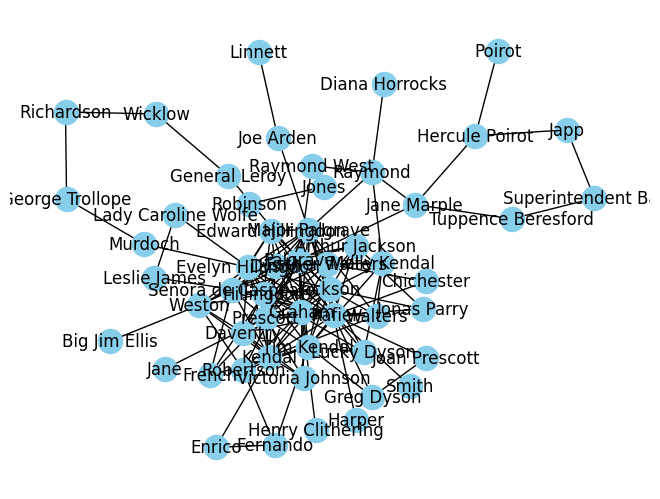

In [71]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Visualização com Pyvis

In [72]:
!pip install pyvis

  Using cached pyvis-0.3.2-py3-none-any.whl.metadata (1.7 kB)
Using cached pyvis-0.3.2-py3-none-any.whl (756 kB)


In [84]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("poirot.html") 

poirot.html


Graus de Centralidade para determinar os personagens mais importantes

In [86]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Esther Walters': 0.24528301886792453,
 'Prescott': 0.2830188679245283,
 'Victoria Johnson': 0.09433962264150943,
 'Major Palgrave': 0.2641509433962264,
 'Palgrave': 0.32075471698113206,
 'Raymond': 0.09433962264150943,
 'Jane Marple': 0.07547169811320754,
 'Raymond West': 0.03773584905660377,
 'Diana Horrocks': 0.018867924528301886,
 'Molly Kendal': 0.1320754716981132,
 'Tim Kendal': 0.24528301886792453,
 'Rafiel': 0.43396226415094336,
 'Graham': 0.33962264150943394,
 'Joe Arden': 0.03773584905660377,
 'Linnett': 0.018867924528301886,
 'Jones': 0.018867924528301886,
 'Robinson': 0.018867924528301886,
 'Hillingdon': 0.32075471698113206,
 'Lucky Dyson': 0.09433962264150943,
 'Evelyn Hillingdon': 0.3018867924528302,
 'Edward Hillingdon': 0.1509433962264151,
 'French': 0.07547169811320754,
 'Dyson': 0.22641509433962265,
 'Kendal': 0.2641509433962264,
 'Chichester': 0.03773584905660377,
 'Jackson': 0.3018867924528302,
 'General Leroy': 0.03773584905660377,
 'Wicklow': 0.03773584905660377,

<Axes: >

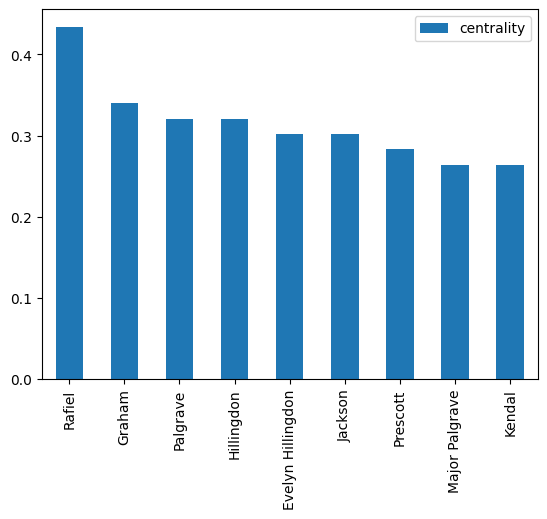

In [87]:
degree_df = pd.DataFrame.from_dict(degree_dict,orient='index',columns=['centrality'])

degree_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")

<Axes: >

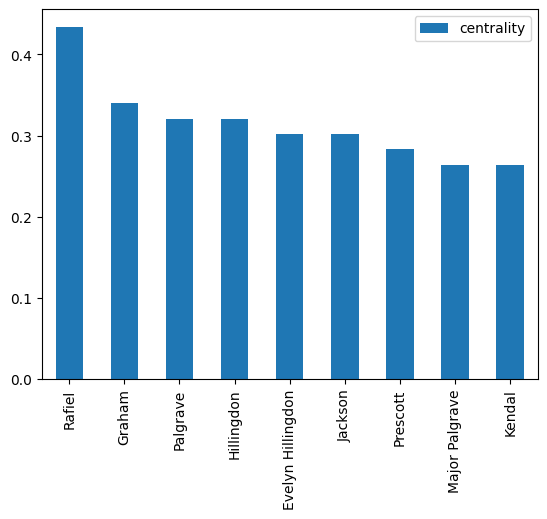

In [88]:
#Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

betweenness_df = pd.DataFrame.from_dict(degree_dict,orient='index',columns=['centrality'])

betweenness_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")

<Axes: >

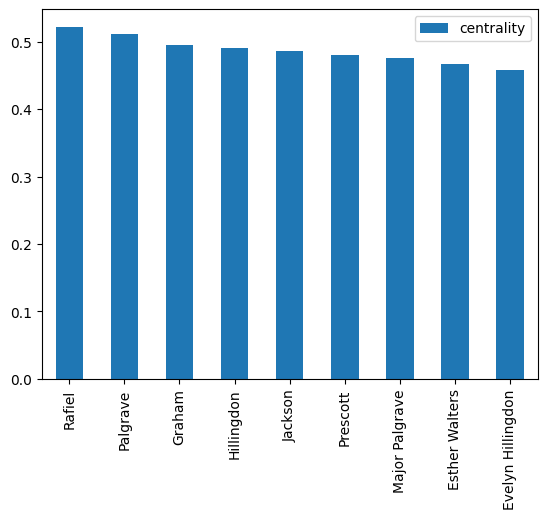

In [89]:
#Proximidade
proximidade_dict = nx.closeness_centrality(G)
proximidade_df = pd.DataFrame.from_dict(proximidade_dict, orient='index',columns=['centrality'])

proximidade_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")


In [90]:
nx.set_node_attributes(G,degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G,proximidade_dict, 'closeness_centrality')


Comunidades

In [92]:
!pip install community

  Using cached community-1.0.0b1-py3-none-any.whl
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)

  Attempting uninstall: werkzeug

    Found existing installation: Werkzeug 3.0.3

    Uninstalling Werkzeug-3.0.3:

      Successfully uninstalled Werkzeug-3.0.3

   ---------------------------------------- 0/5 [werkzeug]
   -------- ------------------------------- 1/5 [itsdangerous]
   ---------------------------------------- 5/5 [community]



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.3 which is incompatible.


In [98]:
import community.community_louvain as community_louvain

In [96]:
!pip install python-louvain

In [99]:
communities = community_louvain.best_partition(G)

In [100]:
communities

{'Esther Walters': 3,
 'Prescott': 3,
 'Victoria Johnson': 1,
 'Major Palgrave': 3,
 'Palgrave': 1,
 'Raymond': 5,
 'Jane Marple': 5,
 'Raymond West': 5,
 'Diana Horrocks': 5,
 'Molly Kendal': 4,
 'Tim Kendal': 4,
 'Rafiel': 4,
 'Graham': 1,
 'Joe Arden': 6,
 'Linnett': 6,
 'Jones': 0,
 'Robinson': 0,
 'Hillingdon': 3,
 'Lucky Dyson': 4,
 'Evelyn Hillingdon': 3,
 'Edward Hillingdon': 3,
 'French': 3,
 'Dyson': 3,
 'Kendal': 1,
 'Chichester': 4,
 'Jackson': 4,
 'General Leroy': 2,
 'Wicklow': 2,
 'Richardson': 2,
 'George Trollope': 2,
 'Murdoch': 2,
 'Lady Caroline Wolfe': 3,
 'Leslie James': 3,
 'Harper': 4,
 'Walters': 4,
 'Jane': 3,
 'Arthur Jackson': 4,
 'Señora de Caspearo': 3,
 'Robertson': 1,
 'Fernando': 1,
 'Daventry': 1,
 'Weston': 1,
 'Big Jim Ellis': 1,
 'Enrico': 1,
 'Henry Clithering': 1,
 'Smith': 4,
 'Jonas Parry': 4,
 'Greg Dyson': 4,
 'Joan Prescott': 4,
 'Hercule Poirot': 5,
 'Tuppence Beresford': 5,
 'Superintendent Battle': 5,
 'Japp': 5,
 'Poirot': 5}

In [101]:
nx.set_node_attributes(G,communities,'group')

In [103]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("agatha_communities.html")

agatha_communities.html
